In [1]:
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn, optim
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
def generate_shift_one_dim_dataset(n, p, q, seed):
    rng = np.random.RandomState(seed)
    
    us1 = rng.binomial(n=1, p=p, size=int(n * q))
    xs1 = rng.uniform(0.0, 10.0, size=int(n * q))
    noise1 = rng.normal(0.0, 20.0, size=int(n * q))
    ys1 = xs1 * xs1 * xs1 + 1 * xs1 * xs1 * xs1 * us1 + noise1
    
    us2 = rng.binomial(n=1, p=p, size=int(n * (1 - q)))
    xs2 = rng.uniform(0.0, 1.0, size=int(n * (1 - q)))
    noise2 = rng.normal(0.0, 20.0, size=int(n * (1 - q)))
    ys2 = xs2 * xs2 * xs2 + 1 * xs2 * xs2 * xs2 * us2 + noise2
    
    xs = np.concatenate((xs1, xs2))
    ys = np.concatenate((ys1, ys2))
    return xs.reshape(-1, 1), ys.reshape(-1, 1)

In [3]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    # scale[scale < 1e-10] = 1.0
    data = (data - mu) / scale
    return data, mu, scale

In [4]:
def get_dataloaders(
    X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed,
):
    X_train, x_train_mu, x_train_scale = standardize(X_train)
    y_train, y_train_mu, y_train_scale = standardize(y_train)
    
    X_val = (X_val - x_train_mu) / x_train_scale
    y_val = (y_val - y_train_mu) / y_train_scale
    
    for i in range(len(y_tests)):
        y_tests[i] = (y_tests[i] - y_train_mu) / y_train_scale
        X_tests[i] = (X_tests[i] - x_train_mu) / x_train_scale

    x_train_mu = x_train_mu.item()
    x_train_scale = x_train_scale.item()
    y_train_mu = y_train_mu.item()
    y_train_scale = y_train_scale.item()
    
    train = TensorDataset(
        torch.Tensor(X_train),
        torch.Tensor(y_train),
    )
    train_loader = DataLoader(
        train, batch_size=int(X_train.shape[0] * 0.25), shuffle=True
    )

    val = TensorDataset(
        torch.Tensor(X_val),
        torch.Tensor(y_val),
    )
    val_loader = DataLoader(val, batch_size=len(val), shuffle=False)

    test_loaders = []
    for i in range(len(y_tests)):
        test = TensorDataset(
            torch.Tensor(X_tests[i]),
            torch.Tensor(y_tests[i]),
        )
        test_loader = DataLoader(test, batch_size=len(test), shuffle=False)
        test_loaders.append(test_loader)

    return (
        X_unstandardized,
        y_unstandardized,
        train_loader,
        val_loader,
        test_loaders,
        X_train[0].shape[0],
        x_train_mu,
        x_train_scale,
        y_train_mu,
        y_train_scale,
    )

In [5]:
def get_shift_one_dim_dataloaders(
    n_train, seed, p_train, q_train, p_tests, q_tests
):
    X_train, y_train = generate_shift_one_dim_dataset(
        n=n_train, p=p_train, q=q_train, seed=seed + 2
    )
    
    X_val, y_val = generate_shift_one_dim_dataset(
        n=int(n_train * 0.2), p=p_train, q=q_train, seed=seed
    )
    
    X_tests = []
    y_tests = []
    X_unstandardized = []
    y_unstandardized = []
    for q_test in q_tests:
        for p_test in p_tests:
            X_test, y_test = generate_shift_one_dim_dataset(
                n=10000, p=p_test, q=q_test, seed=seed + 1
            )
            X_tests.append(X_test)
            y_tests.append(y_test)
            X_unstandardized.append(X_test)
            y_unstandardized.append(y_test)
    
    return (
        get_dataloaders(X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed)
    )

In [6]:
p_tests = [0.5, 0.9]
q_tests = [1, 0.5, 0.1]
X_unstandardized, y_unstandardized, train_loader, val_loader, test_loaders, X_train_shape, x_train_mu, x_train_scale, y_train_mu, y_train_scale = get_shift_one_dim_dataloaders(n_train=7000, seed=42, p_train=0.5, q_train=0.5, p_tests=p_tests, q_tests=q_tests)

In [7]:
l_rate = 0.001 #appropriate learning rate? 1e-2 or 1e-3
mse_loss = nn.MSELoss(reduction = 'mean')

In [8]:
class Regression(pl.LightningModule):
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(1, 1) #how many layers and what size?
        self.validation_losses = []
        self.test_losses = []

    def forward(self, x):
        x = self.fc1(x)  # No activation function?
        return x
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=l_rate) #adam optimizer
    
    def training_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        self.log('val_loss', loss) #why do i get error message w/o this line
        self.validation_losses.append(loss.item())
        return loss

    def on_validation_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.validation_losses) / len(self.validation_losses)
        tensorboard_logs = {'val_loss': avg_loss}
        self.log('avg_val_loss', avg_loss, on_epoch=True, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        breakpoint()
        x, y = batch
        logits = self.forward(x)
        loss = mse_loss(logits, y)
        predictions.append(logits)
        self.test_losses.append(loss.item())
        return loss
    
    def on_test_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.test_losses) / len(self.test_losses)
        logs = {'test_loss': avg_loss}      
        avg_losses.append(avg_loss)
        return avg_loss

In [9]:
model = Regression()
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints/')
trainer = Trainer(max_epochs = 50, callbacks=[checkpoint_callback]) #epochs
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader) #comment out dataloader functions and make loop and pass dataloaders


/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/groups/swager/mliu1785/miniconda3/envs/researc ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorbo

Sanity Checking: 0it [00:00, ?it/s]

/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUs

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [10]:
predictions = []
avg_losses = []
for i, test_loader in enumerate(test_loaders):
    trainer.test(dataloaders=test_loader, ckpt_path="best")
avg_losses

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=49-step=200-v4.ckpt


Testing: 0it [00:00, ?it/s]

[0.962592601776123,
 1.2669618129730225,
 1.038770318031311,
 1.0049705356359482,
 0.8570334732532501,
 0.7677147090435028]

In [11]:
plot_pred = []
for i in range(len(X_unstandardized)):
    test_pred = []
    for j in range(0,2):
        pred = predictions[i][j].item() * y_train_scale + y_train_mu
        test_pred.append(pred)
    plot_pred.append(test_pred)
plot_pred

[[203.52822845638627, -175.21596489724948],
 [203.52822845638627, -175.21596489724948],
 [301.05893449130417, -5.082673027066818],
 [301.05893449130417, -5.082673027066818],
 [187.20428163322634, -110.53733645170047],
 [187.20428163322634, -110.53733645170047]]

In [21]:
%cd ..

/home/groups/swager/mliu1785/linear_ru_reg


In [22]:
trained_model = Regression.load_from_checkpoint('checkpoints/epoch=49-step=200-v4.ckpt')
trained_model.eval()
x1 = 0
x2 = 10
x1_tensor = torch.tensor([[(x1 - x_train_mu) / x_train_scale]], dtype=torch.float32)
x2_tensor = torch.tensor([[(x2 - x_train_mu) / x_train_scale]], dtype=torch.float32) 
with torch.no_grad():
    y1 = trained_model(x1_tensor)[0][0].item() * y_train_scale + y_train_mu
    y2 = trained_model(x2_tensor)[0][0].item() * y_train_scale + y_train_mu
y1, y2

(-195.67711595981342, 540.6763149422995)

[[136.57229683]]
[73.63534054]
[[171.19925885]]
[73.63534054]
[[106.96680962]]
[73.63534528]
[[134.63851741]]
[73.63534528]
[[98.77413474]]
[73.63534602]
[[121.82066396]]
[73.63534602]


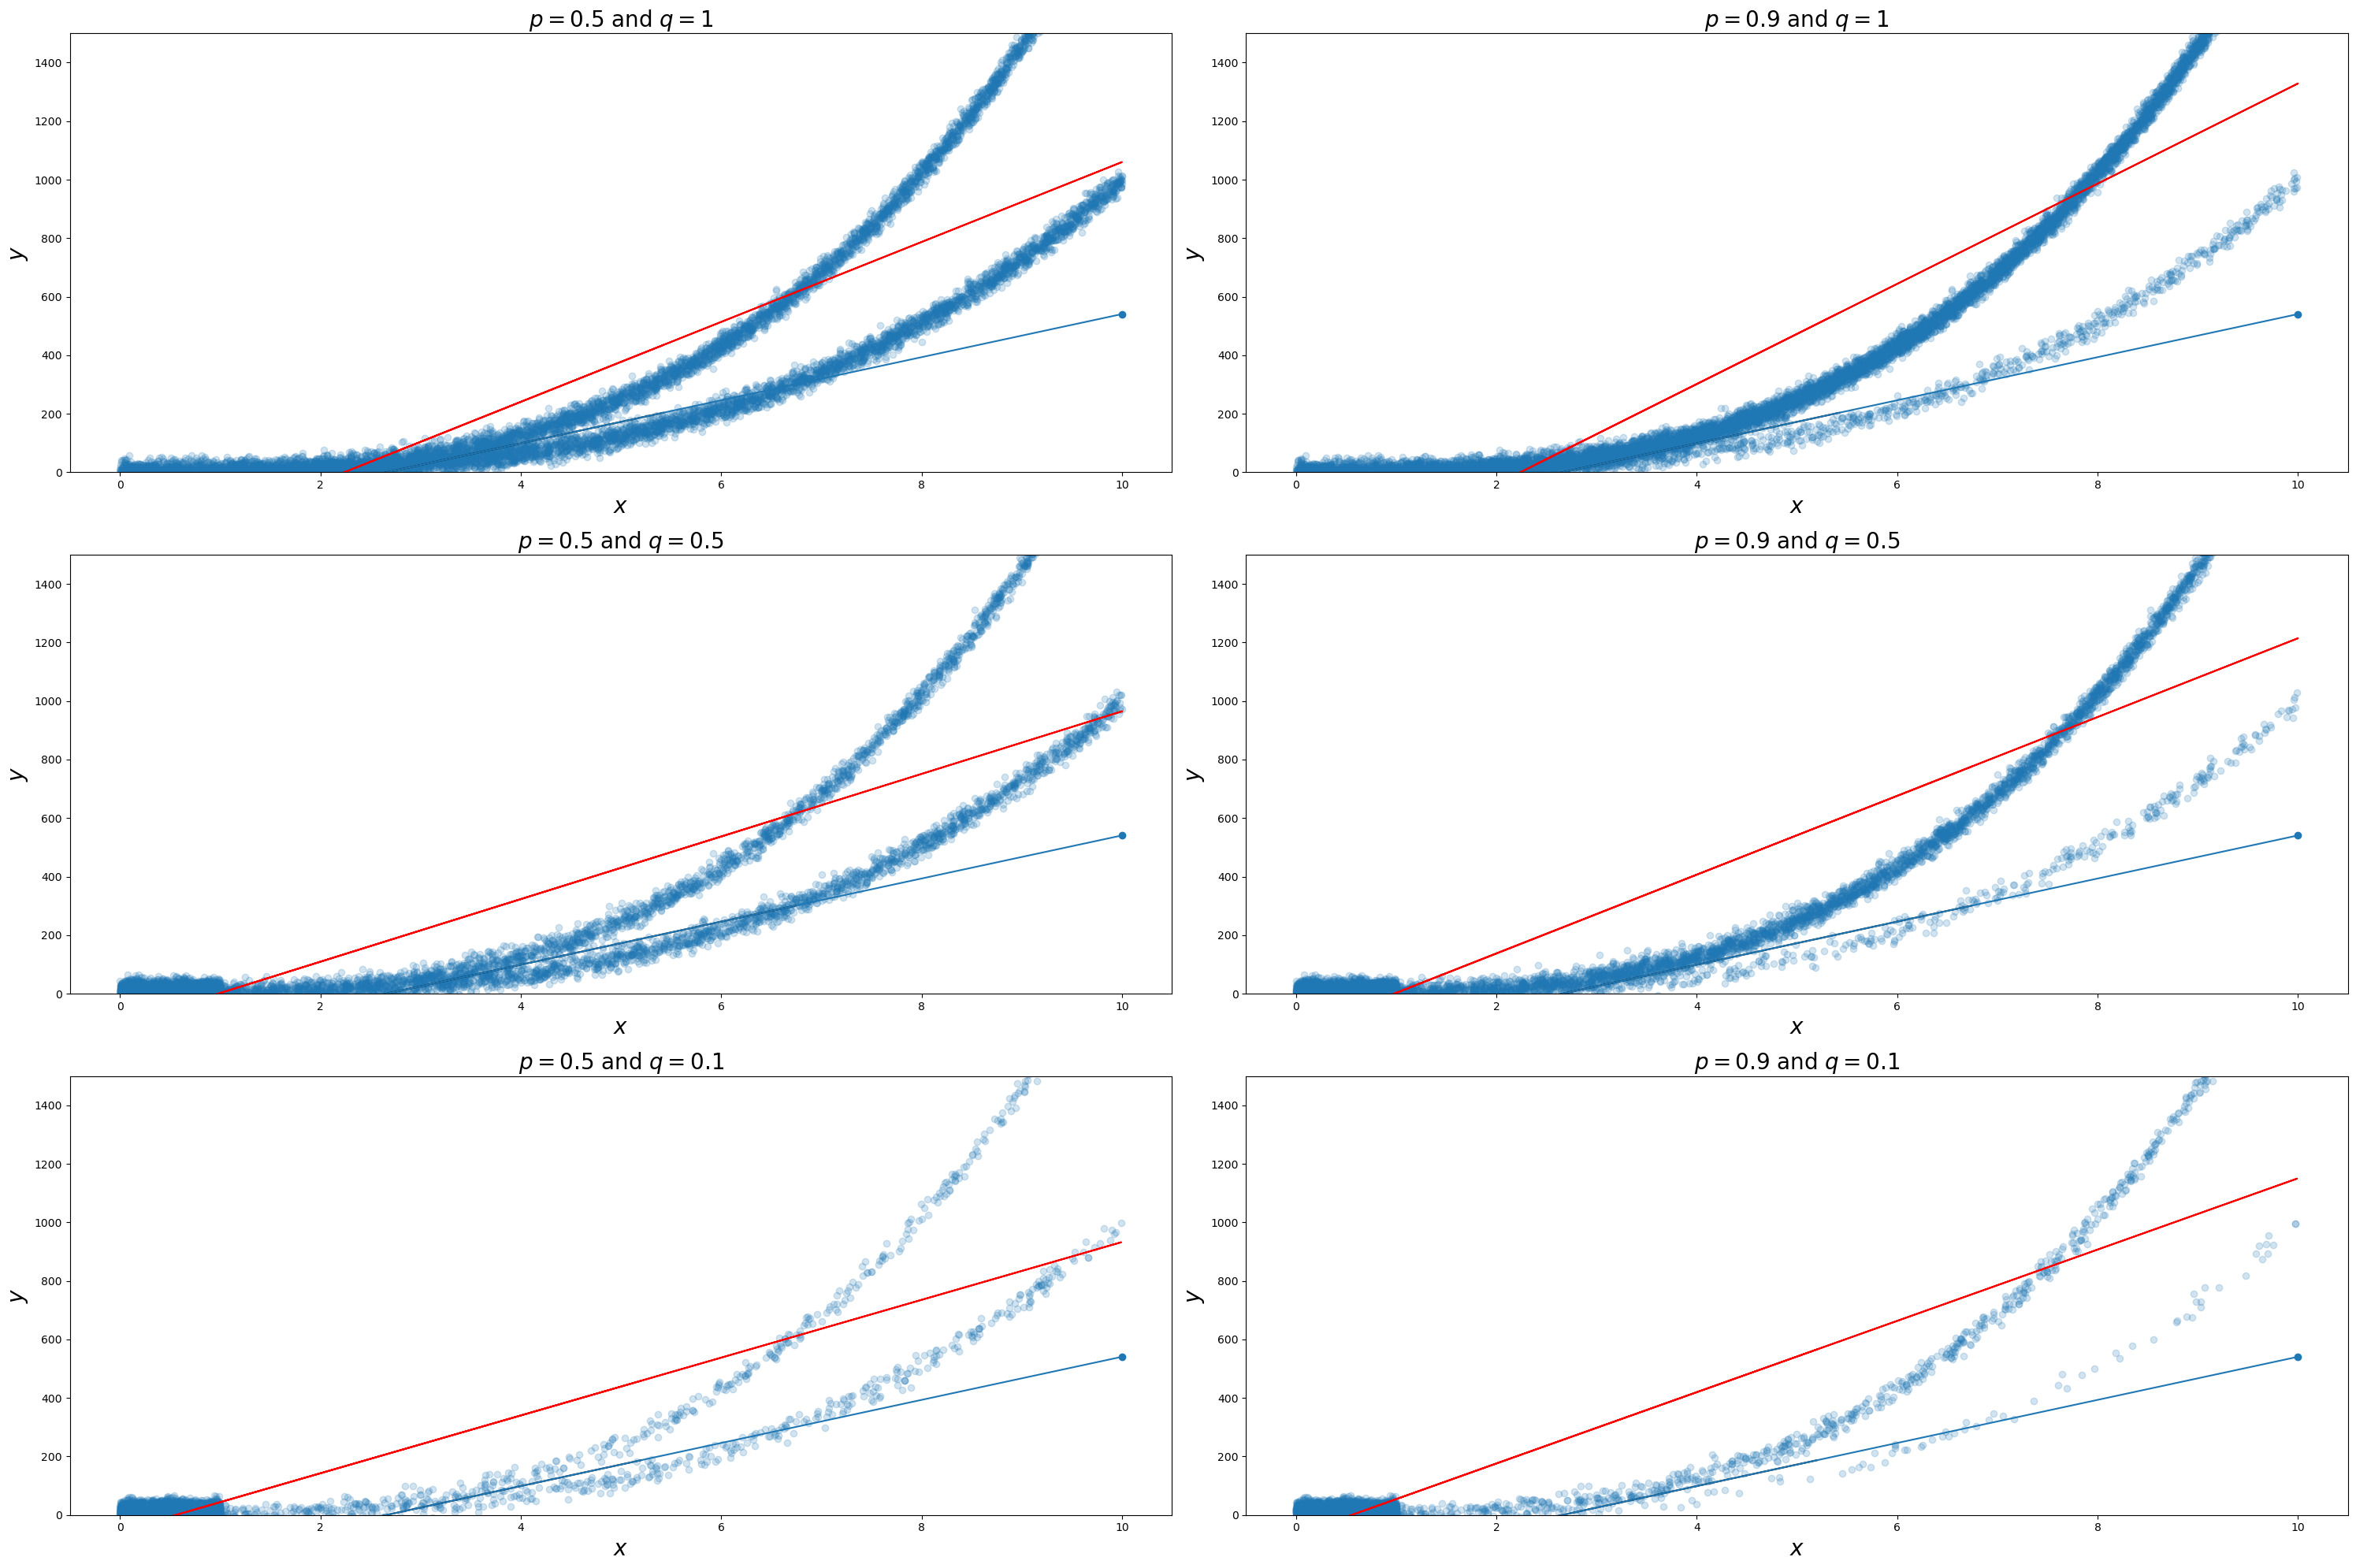

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(30, 20))
ax = ax.flatten();
for i in range(len(X_unstandardized)):
    ax[i].scatter(X_unstandardized[i], y_unstandardized[i], alpha=0.2)
    ax[i].set_title(r"$p={}$".format(round(p_tests[i % 2], 3)) + " and " + r"$q={}$".format(round(q_tests[int(i / 2)], 3)), fontsize=20)
    ax[i].set_xlabel(r"$x$", fontsize=20)
    ax[i].set_ylabel(r"$y$", fontsize=20)
    ax[i].set_ylim(0, 1500)
    
    lobf = LinearRegression()
    lobf.fit(X_unstandardized[i], y_unstandardized[i])
    print(lobf.coef_)
    y_pred = lobf.predict(X_unstandardized[i])
    ax[i].plot(X_unstandardized[i], y_pred, color='red', label='Linear Regression')
    
    first_two = X_unstandardized[i][:2]
    model = LinearRegression()
    model.fit(first_two, plot_pred[i])
    print(model.coef_)
    model_pred = model.predict(first_two)
    ax[i].plot(first_two, model_pred, color='black', label='Linear Regression')
    
    ax[i].plot([x1, x2], [y1, y2], marker='o', label='Points')
    
plt.tight_layout()